In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import networkx as nx
import numpy as np
import pandas as pd
from discreteMarkovChain import markovChain
import os
import glob
import random
from scipy.stats import expon
from smart_open import open
from xml.dom.minidom import parse, Node

In [2]:
all_chars = ['Start/End','ALL', 'ANGUS', 'ATTENDANT', 'BANQUO', 'Both Murderers',
       'CAITHNESS', 'DONALBAIN', 'DUNCAN', 'Doctor', 'FLEANCE',
       'First Apparition', 'First Murderer', 'First Witch', 'Gentlewoman',
       'HECATE', 'LADY MACBETH', 'LADY MACDUFF', 'LENNOX', 'Lord',
       'Lords', 'MACBETH', 'MACDUFF', 'MALCOLM', 'MENTEITH', 'Messenger',
       'Old Man', 'Porter', 'ROSS', 'SEYTON', 'SIWARD',
       'Second Apparition', 'Second Murderer', 'Second Witch', 'Sergeant',
       'Servant', 'Soldiers', 'Son', 'Third Apparition', 'Third Murderer',
       'Third Witch', 'YOUNG SIWARD']

len(all_chars)

c = 0
cd = np.zeros((28,42))
xmlTree = parse(open("macbeth.xml"))
for nodes in xmlTree.getElementsByTagName("SCENE"):
  order_of_speech = []
  scene = nodes.getElementsByTagName("TITLE")[0].childNodes[0].data
  for node in nodes.getElementsByTagName("SPEECH"):
      for i in range(len(node.getElementsByTagName("SPEAKER"))):
          line = node.getElementsByTagName("SPEAKER")[i].firstChild.data
          order_of_speech.append(line)
  d = {x:order_of_speech.count(x) for x in order_of_speech}
  #chars = ["Beginning"]
  chars = ["Start/End"]
  chars += list(d.keys())
  P = np.zeros((len(chars),len(chars)))
  prev = chars.index(order_of_speech[0])
  for s in order_of_speech[1:]:
    current = chars.index(s)
    P[prev][current] += 1
    prev = current
  P[prev][chars.index("Start/End")] += 1
  P[chars.index("Start/End")][chars.index(order_of_speech[0])] += 1
  mapping = {}
  for i,v in enumerate(chars):
      mapping[i]=v
  P /=  P.sum(axis=1)[:,np.newaxis]
  mc = markovChain(P)
  mc.computePi('eigen')
  print("###",scene.split("/")[-1].replace(".htm",""))
  for i in range(len(chars)):
      print("%.4f # %s" % (mc.pi[i],mapping[i]))
      cd[c,all_chars.index(mapping[i])] = mc.pi[i]
  c += 1
  G = nx.DiGraph()
  for n in all_chars:
    G.add_node(n)
  labels={}
  edge_labels={}
  for i, origin_state in enumerate(chars):
      for j, destination_state in enumerate(chars):
          rate = P[i][j]
          if rate > 0:
              G.add_edge(origin_state,
                        destination_state,
                        weight=rate,
                        label="{:.02f}".format(rate))
              edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)

### SCENE I.  A desert place.
0.0909 # Start/End
0.2727 # First Witch
0.2727 # Second Witch
0.2727 # Third Witch
0.0909 # ALL
### SCENE II.  A camp near Forres.
0.0526 # Start/End
0.4211 # DUNCAN
0.1053 # MALCOLM
0.1579 # Sergeant
0.0526 # LENNOX
0.2105 # ROSS
### SCENE III.  A heath near Forres.
0.0192 # Start/End
0.1731 # First Witch
0.1154 # Second Witch
0.1154 # Third Witch
0.0192 # ALL
0.2500 # MACBETH
0.2308 # BANQUO
0.0385 # ROSS
0.0385 # ANGUS
### SCENE IV.  Forres. The palace.
0.0833 # Start/End
0.5000 # DUNCAN
0.0833 # MALCOLM
0.2500 # MACBETH
0.0833 # BANQUO
### SCENE V.  Inverness. Macbeth's castle.
0.0833 # Start/End
0.5000 # LADY MACBETH
0.1667 # Messenger
0.2500 # MACBETH
### SCENE VI.  Before Macbeth's castle.
0.1250 # Start/End
0.5000 # DUNCAN
0.1250 # BANQUO
0.2500 # LADY MACBETH
### SCENE VII.  Macbeth's castle.
0.0714 # Start/End
0.5000 # MACBETH
0.4286 # LADY MACBETH
### SCENE I.  Court of Macbeth's castle.
0.0588 # Start/End
0.4706 # BANQUO
0.1176 # FLEANCE
0.3529

0.0 10.9734
0.0 19.1775
0.0 51.9833
0.0 11.9088
0.0 12.0349
0.0 8.071
0.0 14.2017
0.0 17.0508
0.0 29.1403
0.0 56.3188
0.0 21.9267
0.0 32.5145
0.0 15.3225
0.0 21.1062
0.0 54.8004
0.0 3.9822
0.0 6.8681
0.0 54.5867
0.0 42.3731
0.0 65.0809
0.0 33.2697
0.0 10.8775
0.0 21.2548
0.0 10.9455
0.0 12.0457
0.0 3.9689
0.0 13.7918


No handles with labels found to put in legend.


0.0 23.6091


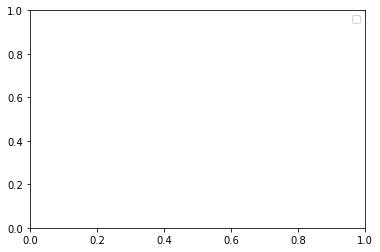

In [3]:
number = 10000
alphas = []
kwargs = dict(alpha=0.5, bins=100, density=True)
np.random.seed(int.from_bytes(os.urandom(4), byteorder='little')) 
#fig = plt.figure(figsize=(22.5,5))
for i in range(28):
    avg = []
    for k in range(number):
        char_order = []
        for t in range(500):
            random_character = all_chars[np.random.choice(42, 1, p=cd[i,:])[0]]
            char_order.append(random_character)
            if random_character == "Start/End":
                break
        avg.append(len(char_order))
    avg.sort(reverse=True)
    #ax = fig.add_subplot(1,28,i+1)
    #ax.hist(avg, **kwargs, color=np.random.rand(3,))
    #ax.set_title(labels[i])
    loc, scale = expon.fit(avg, floc=0)
    print(loc, scale)
    #x = np.linspace(0,max(avg),1000)
    #y = expon.pdf(x, shape, loc, scale)
    #ax.plot(x, y)
    alphas.append(scale)

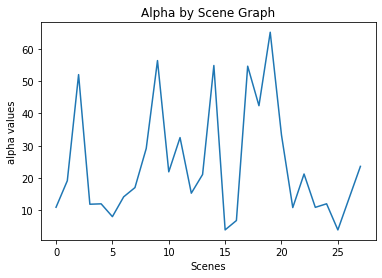

In [4]:
plt.plot(range(28),alphas)
plt.xlabel('Scenes')
plt.ylabel('alpha values')
plt.title('Alpha by Scene Graph')
plt.savefig('figures/macbeth_alpha.png')